# Using ehrapy with large datasets

Modern health datasets can become very large. When datasets are so large they cannot be loaded into a computer's memory at once, loading and processing the data in batches becomes necessary. This is also called doing the computations "out-of-core".

[`dask`](https://www.dask.org) is a popular out-of-core, distributed array processing library that ehrapy is beginning to support.  Here we walk through a quick tutorial of using `dask` in a simple analysis task.

:::{warning} 🔪 **Beware sharp edges!** 🔪

`dask` support in `ehrapy`, leveraging `scanpy` functionality, is new and highly experimental!

Many functions in `ehrapy` **do not** support `dask` and may exhibit unexpected behaviour if dask arrays are passed to them. Stick to what's outlined in this tutorial and you should be fine!

Please report any issues you run into over on the issue tracker.
:::

## Setup

This notebook relies on optional dependencies in dask. Install them with:

```sh
pip install -U "dask[array,distributed,diagnostics]" dask-ml
pip install sklearn_ann
pip install annoy
```

In [11]:
from pathlib import Path

import numpy as np
import dask.distributed as dd
import dask.array as da
from dask_ml.datasets import make_blobs
import ehrapy as ep
import anndata as ad
import h5py

## Example Usecase

For simplicity, we will generate and use synthetic data example here to follow through an illustration.

In [23]:
n_individuals = 100
n_features = 4
chunks = (1000,1000)

In [24]:
dataset = make_blobs(n_samples=n_individuals, n_features=n_features, centers=4, random_state=42,
                     chunks=chunks)

In [25]:
adata = ad.AnnData(X=dataset[0], obs={"label":dataset[1]})
adata

AnnData object with n_obs × n_vars = 100 × 4
    obs: 'label'

We can write the dataset to disk:
TODO: write to disk and then read?

For more information on using distributed computing via `dask`, please see their [documentation](https://docs.dask.org/en/stable/deploying-python.html). In short, one needs to define both a cluster and a client to have some degree of control over the compute resources dask will use. It's very likely you will have to tune the number of workers and amount of memory per worker along with your chunk sizes.

In [28]:
cluster = dd.LocalCluster(n_workers=3)
client = dd.Client(cluster)

Dask provides extensive tooling for monitoring your computation. You can access that via the dashboard started when using any of their distributed clusters.

In [29]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:46089/status,
Dashboard: http://127.0.0.1:46089/status,Workers: 3
Total threads: 9,Total memory: 15.40 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35741,Workers: 3
Dashboard: http://127.0.0.1:46089/status,Total threads: 9
Started: Just now,Total memory: 15.40 GiB
Comm: tcp://127.0.0.1:33501,Total threads: 3
Dashboard: http://127.0.0.1:40201/status,Memory: 5.13 GiB
Nanny: tcp://127.0.0.1:33643,


A number of ehrapy functions already can operate completely lazy. That means it will look like nothing is computed when you call an operation on a dask array, but only later when you hit compute.

In some cases it's currently unavoidable to skip all computation, and these cases will kick off compute for all the delayed operations immediately.

In [36]:
%%time
adata.layers["raw"] = adata.X.copy()  # Making sure we keep access to the raw counts
ep.pp.scale_norm(adata)

CPU times: user 161 ms, sys: 15.7 ms, total: 177 ms
Wall time: 286 ms


AnnData object with n_obs × n_vars = 100 × 4
    obs: 'label'
    var: 'feature_type'
    uns: 'normalization'
    layers: 'raw', 'raw_norm'

Group characterizing feature computation needs to add entries into `obs`, which currently does not support lazy column. So computation will occur immediately on call.

In [41]:
%%time
ep.tl.rank_features_groups(adata, groupby = "label",  num_cols_method="t-test")

CPU times: user 3.89 s, sys: 420 ms, total: 4.31 s
Wall time: 7.86 s


PCA is a common dimensionality reduction technique, representing the data in lower-dimensional space which aims to keep as much variance in the data as possible.
It can deal with large data in ehrapy by using dask under the hood:

In [44]:
%%time
ep.pp.pca(adata)

CPU times: user 480 ms, sys: 61.1 ms, total: 541 ms
Wall time: 884 ms


While most of the PCA computation runs immediately, the last step (computing the observation loadings) is lazy, so must be triggered manually to avoid recomputation.

In [45]:
%%time
adata.obsm["X_pca"] = adata.obsm["X_pca"].compute()

CPU times: user 204 ms, sys: 28.4 ms, total: 233 ms
Wall time: 347 ms


In [46]:
adata

AnnData object with n_obs × n_vars = 100 × 4
    obs: 'label'
    var: 'feature_type'
    uns: 'normalization', 'rank_features_groups', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw', 'raw_norm'

Now that we've computed our PCA let's take a look at it:

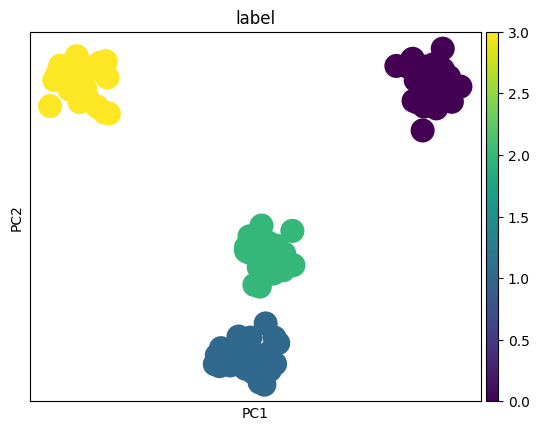

In [47]:
ep.pl.pca(adata, color="label")

Further support for `dask` is a work in progress. However, many operations past this point can work with the dimensionality reduction directly in memory. Many of these operations can be accelerated to make working with large datasets significantly easier. For example:

* Using alternative KNN backends for faster neighbor calculation {doc}`/how-to/knn-transformers`
* Using the `igraph` backend for clustering

In [50]:
%%time
from sklearn_ann.kneighbors.annoy import AnnoyTransformer  # noqa: E402

transformer = AnnoyTransformer(n_neighbors=15)
ep.pp.neighbors(adata, transformer=transformer)

TypeError: neighbors() got an unexpected keyword argument 'transformer'

In [51]:
# TODO: potentially add transformer to ep.pp.neighbors. for now:
ep.pp.neighbors(adata)

In [53]:
%%time
ep.tl.leiden(adata, n_iterations=2)

CPU times: user 43.1 ms, sys: 7.77 ms, total: 50.9 ms
Wall time: 52 ms


UMAP computation can still be rather slow:

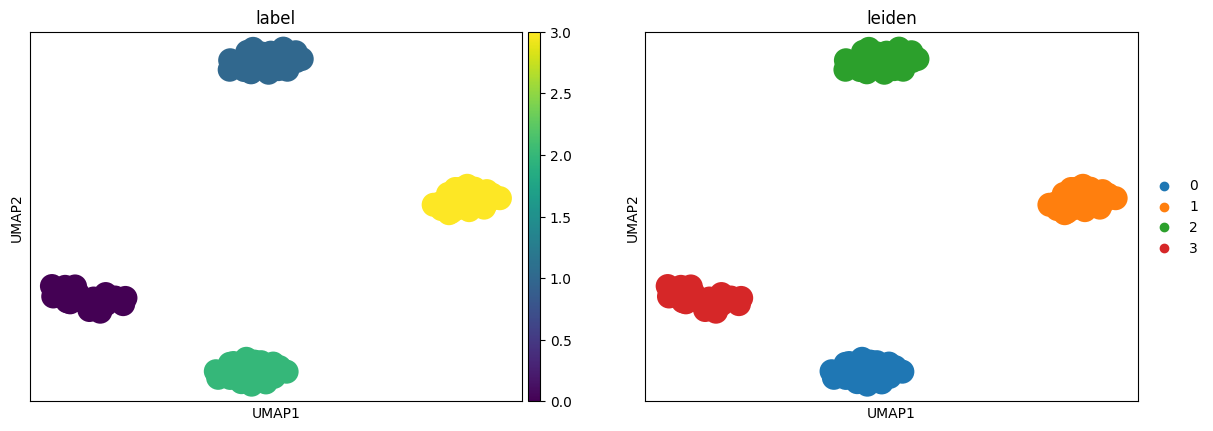

CPU times: user 6.26 s, sys: 595 ms, total: 6.85 s
Wall time: 6.18 s


In [54]:
%%time
ep.tl.umap(adata)
ep.pl.umap(adata, color=["label", "leiden"])